#### Problem Statement - 
<br> This is an example of simplified classification model.
<br> Objective of this exercise is to predict if we can approve car loans for some applicants.
<br> Train data provided with TARGET variable 1 or 0. We have to run and check performance on TEST data
                        
### Contents -
#### Exploratory Data Analysis<br> 
<br> -  Looking at Data<br> -  Plot and visualze Categorial Variables<br> -  
Corelation and plot Neumerical variables<br> -  Missing Value Stats<br> 
####  Phase 1 Modeling
<br> -  Simple way of missing value Imputation<br> -  Model preperation<br> -  Random Forest - grid search,
hyperparameter tuning and evaluation of best model by cross validation<br> -  XGboost - 
hyperparameter tuning,random search and evaluation of best model by cross validation
<br> -  Conclusion from Phase 1 <br> 
####  Phase 2 Modeling 
<br> -  Missing value imputation by KNN<br> -  Random Forest<br> -  XGboost<br> - Is there any improvement ?<br> 
#### Implementation on Test and Final Submission
#### Conclusion and Future Work


### Required Modules

In [144]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from time import time
import datetime
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
import gc
import json
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")


#### Loading Data

In [125]:
file_path="/Users/krishanubanerjee/Downloads/prestige_finance/Use"
    
train=pd.read_csv(file_path+"/application_train.csv")
test=pd.read_csv(file_path+"/application_test.csv")

### 1. Exploratory Data Analysis (EDA)

####   Looking at data

In [4]:
train.shape

(125000, 122)

In [5]:
test.shape

(48744, 121)

In [6]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,396902,0,Cash loans,F,Y,Y,0,121500.0,835380.0,40320.0,675000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.035792,-16647,-283,-611.0,-184,10.0,1,1,1,1,0,0,Core staff,1.0,2,2,SUNDAY,11,0,0,0,0,0,0,Restaurant,0.642816,0.606592,0.646330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-770.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
1,112096,0,Cash loans,F,N,Y,0,202500.0,516069.0,26478.0,445500.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.011657,-22237,365243,-34.0,-4878,NaN,1,0,0,1,0,0,NaN,1.0,1,1,WEDNESDAY,10,0,0,0,0,0,0,XNA,NaN,0.172095,0.360613,0.1227,0.1213,0.9762,0.6736,0.1901,0.00,0.2069,0.1667,0.0417,0.0476,0.1000,0.0941,0.0000,0.1375,0.1250,0.1259,0.9762,0.6864,0.1918,0.0000,0.2069,0.1667,0.0417,0.0487,0.1093,0.0981,0.0000,0.1456,0.1239,0.1213,0.9762,0.6780,0.1913,0.00,0.2069,0.1667,0.0417,0.0485,0.1018,0.0958,0.0000,0.1404,reg oper spec account,block of flats,0.1039,"Stone, brick",No,1.0,1.0,1.0,1.0,-1069.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0
2,285821,1,Cash loans,M,Y,Y,1,180000.0,284400.0,22468.5,225000.0,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,0.028663,-11399,-508,-1500.0,-920,16.0,1,1,0,1,0,0,Laborers,3.0,2,2,SUNDAY,11,0,1,1,0,1,1,Construction,0.446722,0.465626,0.106156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,7.0,0.0,-933.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
3,376901,0,Ca

##### Is there any primary key ?

In [231]:
[list(train.columns)[i] for i in range(len(list(train.columns))) \
                     if train[list(train.columns)[i]].nunique()==train.shape[0]]

['SK_ID_CURR']

##### Is it true for test also ?

In [10]:
[list(test.columns)[i] for i in range(len(list(test.columns))) \
                     if test[list(test.columns)[i]].nunique()==test.shape[0]]

['SK_ID_CURR']

<br> So we confirmed ,'SK_ID_CURR' is primary key and we will use this field for indexing in modeling<br>

##### Let's see target

In [11]:
train['TARGET'].value_counts(normalize=True)

0    0.918936
1    0.081064
Name: TARGET, dtype: float64

<br> 8% of TARGET in one class and 92% in other. That could be little challenging at the time of modeling<br>

#### Let's separate numerical and categorical variables

In [23]:
numerical_features=[features[i] for i in range(len(features)) \
                     if ((train[features[i]].dtypes=='float64')|(train[features[i]].dtypes=='int64')) and \
                            features[i]!='TARGET']

In [24]:
categorical_features=[features[i] for i in range(len(features)) \
                     if (train[features[i]].dtypes!='float64')&(train[features[i]].dtypes!='int64')]

##### Top5 numerical features corelated with TARGET

In [84]:
coeff=[]
for num in numerical_features:
    coeff.append(np.corrcoef(train[num], train['TARGET'])[0][1])
df_numercial_coeff_target=pd.DataFrame(zip(numerical_features,coeff),columns=['feature','coefficient'])
df_numercial_coeff_target.sort_values(by='coefficient',ascending=False).head(5)

,feature,coefficient
7,DAYS_BIRTH,0.081524
20,REGION_RATING_CLIENT_W_CITY,0.061044
19,REGION_RATING_CLIENT,0.059906
78,DAYS_LAST_PHONE_CHANGE,0.056998
10,DAYS_ID_PUBLISH,0.053369


In [85]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate Distribution of of numeric data
    This function will give an idea of numerical data and can be extended for any
    numerical variables"""
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()

,count,mean,std,min,25%,50%,75%,max
DAYS_BIRTH,125000.0,-16043.327896,4367.787586,-25229.0,-19692.00,-15754.0,-12415.0,-7489.0
REGION_RATING_CLIENT_W_CITY,125000.0,2.031768,0.503262,1.0,2.00,2.0,2.0,3.0
REGION_RATING_CLIENT,125000.0,2.052328,0.509721,1.0,2.00,2.0,2.0,3.0
DAYS_LAST_PHONE_CHANGE,125000.0,-965.803944,828.138874,-4121.0,-1573.25,-760.0,-277.0,0.0
DAYS_ID_PUBLISH,125000.0,-2995.506800,1512.924375,-6551.0,-4304.00,-3260.0,-1713.0,0.0


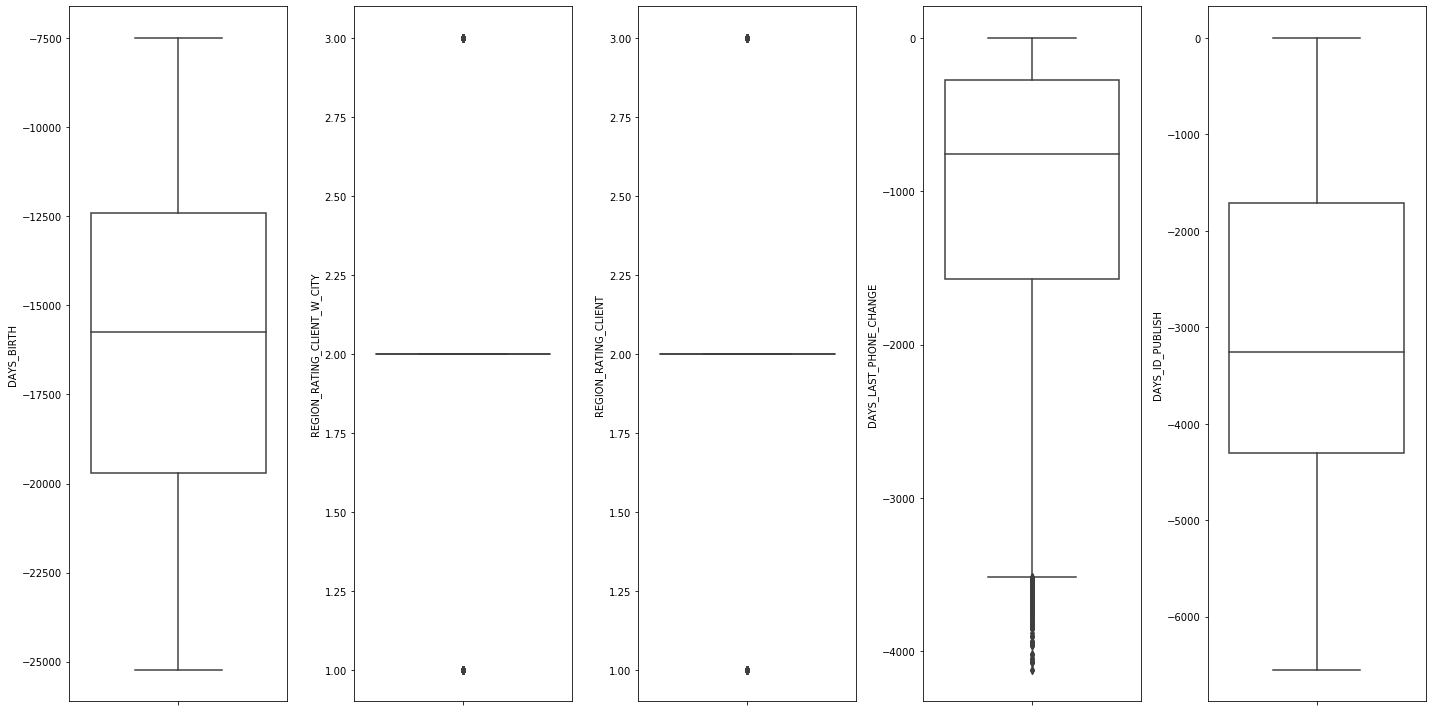

In [86]:
numercial_coeff_target_col=list(df_numercial_coeff_target.sort_values(by='coefficient',\
                                                            ascending=False).head(5)['feature'])
numeric_eda(train[numercial_coeff_target_col])

In [87]:
def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data and relation with TARGET"""
    # Plot count distribution of categorical data
    for col in list(categorical_features):
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()

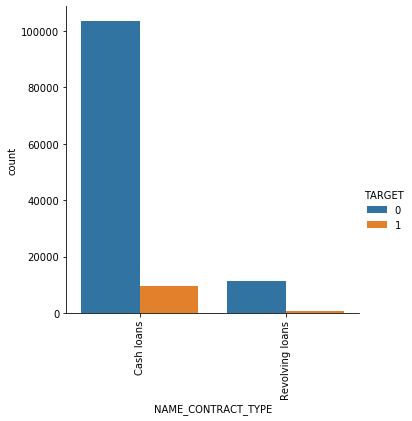

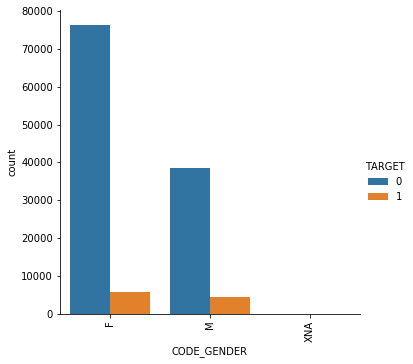

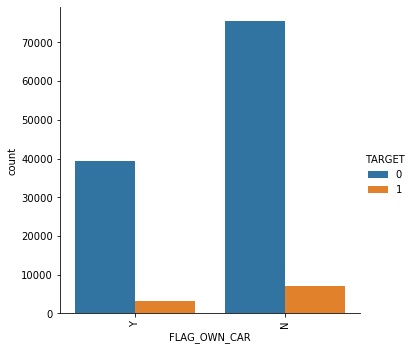

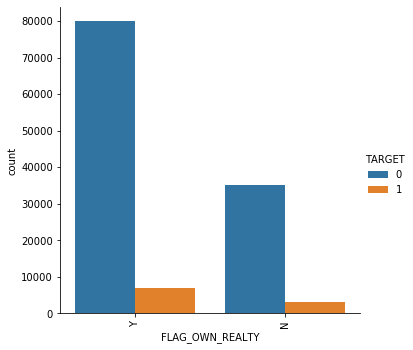

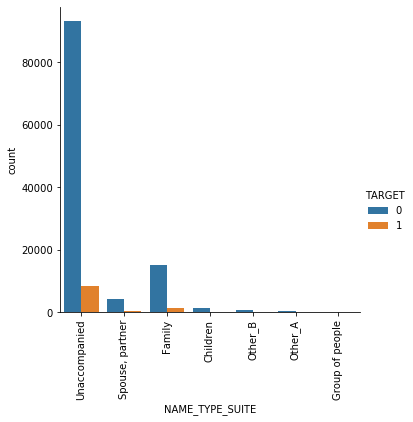

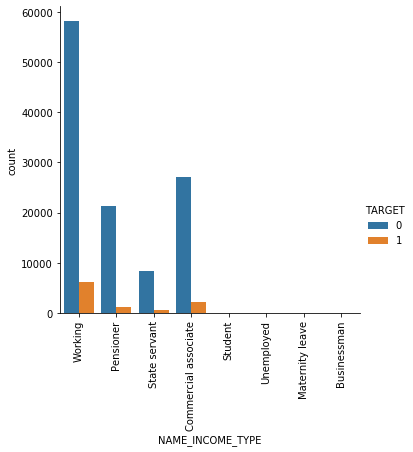

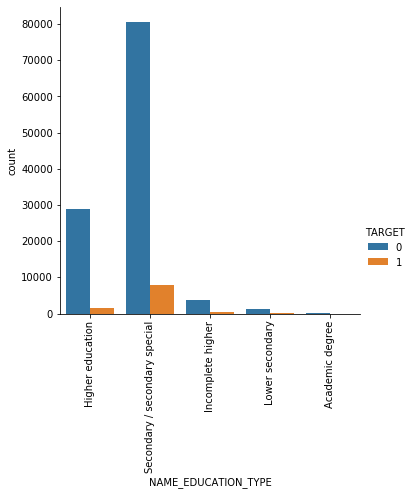

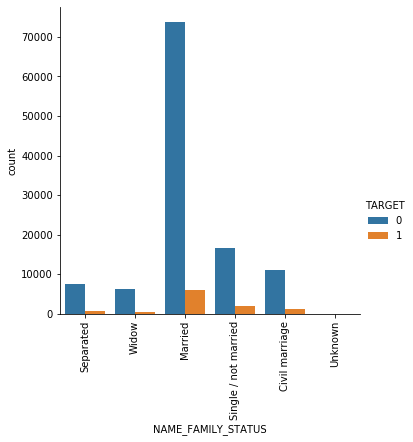

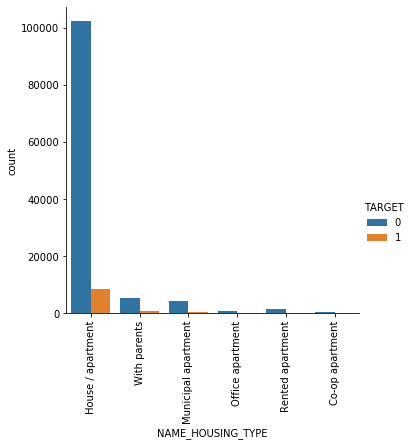

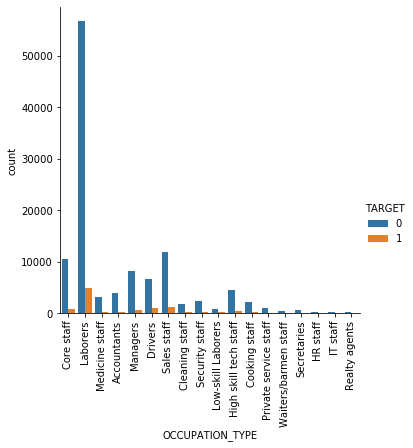

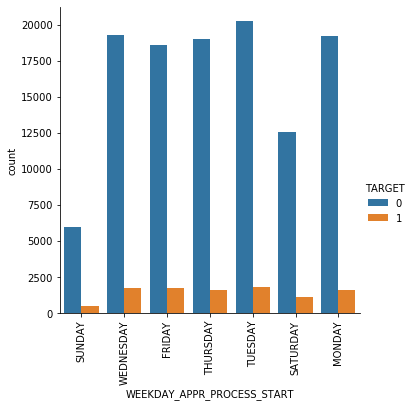

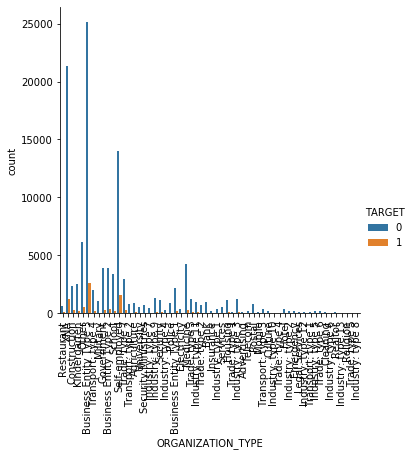

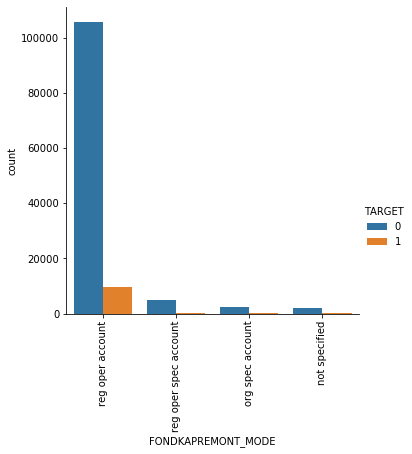

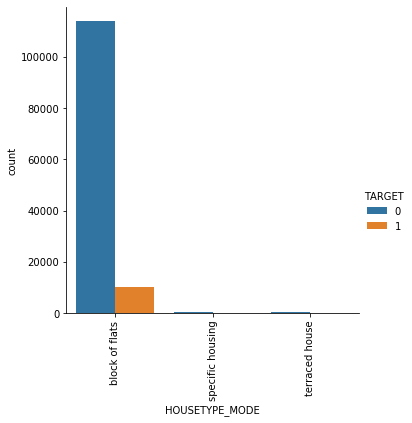

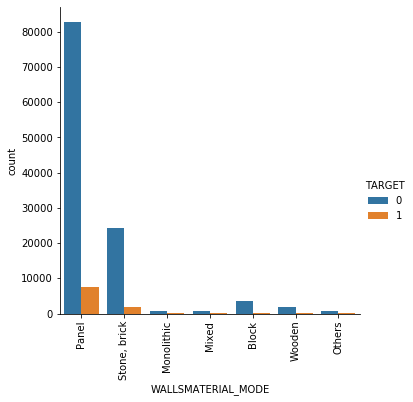

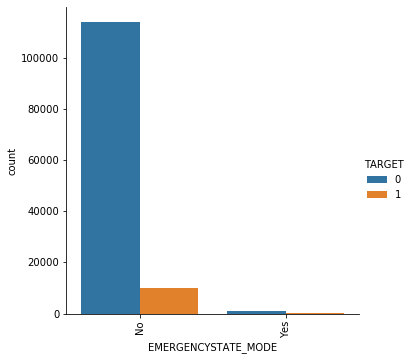

In [88]:
categorical_eda(train,'TARGET')

#### Missing Value

In [92]:
features=list(train.columns)
columns_to_drop=[]
for column in features:
    missing_prcntg=round(train[column].isnull().sum()/len(train),2)
    if missing_prcntg >= .6 :
        print (column+' - '+str(missing_prcntg))
        columns_to_drop.append(str(column))
print(len(columns_to_drop))

OWN_CAR_AGE - 0.66
YEARS_BUILD_AVG - 0.66
COMMONAREA_AVG - 0.7
FLOORSMIN_AVG - 0.68
LIVINGAPARTMENTS_AVG - 0.68
NONLIVINGAPARTMENTS_AVG - 0.69
YEARS_BUILD_MODE - 0.66
COMMONAREA_MODE - 0.7
FLOORSMIN_MODE - 0.68
LIVINGAPARTMENTS_MODE - 0.68
NONLIVINGAPARTMENTS_MODE - 0.69
YEARS_BUILD_MEDI - 0.66
COMMONAREA_MEDI - 0.7
FLOORSMIN_MEDI - 0.68
LIVINGAPARTMENTS_MEDI - 0.68
NONLIVINGAPARTMENTS_MEDI - 0.69
16


#### What we can observe from EDA

 <br> For 16 columns missing value percentage is more than 60%<br> If we change to 50% then we can 
see for 41 columns. Missing value percentage is very high<br> Among the neumerical variables , DAYS_BIRTH 
is showing the highest corelation with TARGET. This distribution is also normal <br> REGION_RATING_CLIENT_W_CITY and 
REGION_RATING_CLIENT -these two fields are showing good correlation with target. But their distribution is 
very unusual and need more data analysis for this fields <br> DAYS_LAST_PHONE_CHANGE is right skewed distribution 
and that is expected <br> For better understanding of numerical variables, more analysis required <br> For all categorical variables, we can see more TARGET 0 than 1 and it is expected as ratio of TARGET 0 to TARGET 1 is 92:8 
<br> Some iteresting observations- for example, CODE_GENDER ratio of TARGET 1 to 0, is more for 'M' than 'W'.<br>
For NAME_EDUCATION_TYPE , 'Secondary' has more TARGET 1 to 0 ratio than other categories <br> for NAME_TYPE_SUITE, 
'Unaccompanied' has more TARGET 1 to 0 ratio <br> In general, some interesting observation,
we can find from EDA but more in depth EDA required for better understanding of the data

### Phase 1 Modeling

#### Missing Value Imputation

#### First of all, we will drop features more than 60% null value

In [93]:
numerical_features=list(set(numerical_features)-set(columns_to_drop))

##### Neumerical features missing values will be replaced by mean of that column

In [94]:
train[numerical_features]=train[numerical_features].fillna(train[numerical_features].mean())

In [95]:
test[numerical_features]=test[numerical_features].fillna(test[numerical_features].mean())

##### Categorical Features missing values will be replaced by most frequest observation

In [96]:
categorical_features=list(set(categorical_features)-set(columns_to_drop))

In [98]:
imp_mean = SimpleImputer( strategy='most_frequent')
imp_mean.fit(train[categorical_features])
train[categorical_features] = imp_mean.transform(train[categorical_features])
imp_mean.fit(test[categorical_features])
test[categorical_features] = imp_mean.transform(test[categorical_features])

In [99]:
reduce_train=train[list(set(features)-set(columns_to_drop))]
reduce_train=pd.get_dummies(reduce_train)
reduce_train.shape

(125000, 230)

In [100]:
reduce_test=test[list(set(features)-set(columns_to_drop)-{'TARGET'})]
reduce_test=pd.get_dummies(reduce_test)
reduce_test.shape

(48744, 226)

##### There are some features in train but not in test. We will drop any feature if not in test

In [101]:
features=list(set(reduce_test.columns)|{'TARGET'})
reduce_train=reduce_train[features]
reduce_train.shape

(125000, 227)

##### Is there any useless feature ?

In [102]:
[features[i] for i in range(len(features)) if reduce_train[features[i]].mean()==0]

[]

##### If two numerical features have corelation coefficient > .99 we will drop one of them

In [118]:
to_reduce=[]
for feat_a in numerical_features:
    for feat_b in numerical_features:
        if feat_a != feat_b and feat_a not in to_reduce and feat_b not in to_reduce:
            c = np.corrcoef(train[feat_a], train[feat_b])[0][1]
            if c > 0.99:
                to_reduce.append(feat_b)

In [119]:
to_reduce

[]

##### Check if any missing value exist

In [104]:
[list(reduce_train.columns)[i] for i in range(len(reduce_train.columns)) if \
         reduce_train[list(reduce_train.columns)[0]].isnull().values.any()==True]

[]

In [105]:
[list(reduce_test.columns)[i] for i in range(len(reduce_test.columns)) if \
         reduce_test[list(reduce_test.columns)[0]].isnull().values.any()==True]

[]

### Model preparation

In [106]:
reduce_train=reduce_train.set_index(['SK_ID_CURR'])
reduce_test=reduce_test.set_index(['SK_ID_CURR'])

#### For final evaluation of different models  , seperating 10% of data

In [107]:
indices=reduce_train.index.values
labels = np.array(reduce_train['TARGET'])
model_features= reduce_train.drop('TARGET', axis = 1)
model_features = np.array(model_features)
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(model_features, labels,indices, test_size = 0.1, random_state = 42)

#### Base Model - Logistic regression

In [108]:
clf = LogisticRegression(random_state=0).fit(train_features, train_labels)

##### Let's define two functions for getting different metrices for score and error analysis later

In [109]:
def get_roc_curve_auc(model,features,labels):
    """ This function will take model, features and prediction labels and
    produce ROC curve with AUC value for train,eval data sets"""
    probs = model.predict_proba(features)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [110]:
def get_accuracy_for_target1_for_thresold(model,features,labels,thresold):
    """ Purpose of this function is to check accuracy when TARGET 1 with 
        overall accuracy,FP,FN for given thresold also to see data for error analysis
        input - model (random forest,xgboost etc.)
        features and labels (train,eval,test etc) and thresold
        output- accuracy for target 1,overall accuracy,FP,FN"""
    df_ana=pd.DataFrame(list(zip(model.predict_proba(features)[:,0],\
                    model.predict_proba(features)[:,1],labels)),\
                    columns=['prob_0','prob_1','true'])
    # check accuracy when true label=1
    df_ana_1=df_ana[df_ana['true']==1]
    df_ana_1['prob_1_thrshold']=np.where(df_ana_1['prob_1']>thresold,1,0)
    print('accuracy for target=1 :  '+ str(df_ana_1['prob_1_thrshold'].sum()/df_ana_1.shape[0]))
    
    df_ana['prob_1_thrshold']=np.where(df_ana['prob_1']>thresold,1,0)

    print('accuracy  : '+str(df_ana[df_ana['prob_1_thrshold']==\
                                          df_ana['true']].shape[0]/df_ana.shape[0]))
    print('FP : '+str(df_ana[(df_ana['prob_1_thrshold']==1)&(df_ana['true']==0)]\
                                          .shape[0]/df_ana.shape[0]))
    print('FN : '+str(df_ana[(df_ana['prob_1_thrshold']==0)&(df_ana['true']==1)]\
                      .shape[0]/df_ana.shape[0]))

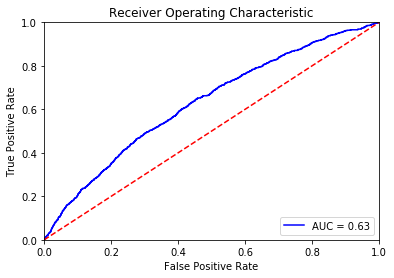

In [111]:
get_roc_curve_auc(clf,eval_features,eval_labels)

In [113]:
get_accuracy_for_target1_for_thresold(clf,train_features,train_labels,.1)

accuracy for target=1 :  0.45766041030117854
accuracy  : 0.6938044444444444
FP : 0.2620177777777778
FN : 0.04417777777777778


In [112]:
get_accuracy_for_target1_for_thresold(clf,eval_features,eval_labels,.1)

accuracy for target=1 :  0.4716202270381837
accuracy  : 0.69448
FP : 0.26456
FN : 0.04096


##### Conclusion from base model

<br> Base model accuracy apparently not too bad . But we have 90% TARGET 0, that means without doing any modeling <br>
if we put 0 for all target still overall accuracy will be 90%. That is why we are interested to know accuracy for <br>
TARGET 1. We can see here FP is really high if we lower thresold to .1. Good part is that not much difference in<br> 
traing and evaluation performance,i.e. not much overfitting  <br> Let's try some ensemble methods


#### Random Forest

##### We will run extensive grid search for pypermeter tuning to get best Random Forest(RF) model
##### All models will be cross validated (CV)
##### In the code below, I ran 36 models (total 180) including CV took around 1 hr in local machine

In [255]:
%%time
forest = RandomForestClassifier()
n_estimators = [50,200,500]
max_depth = [3,5,10]
min_samples_split = [2,5]
min_samples_leaf = [1,3] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, n_jobs = -1)
bestF = gridF.fit(train_features, train_labels)
print(bestF.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 56.5min finished


{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
CPU times: user 5.68 s, sys: 466 ms, total: 6.15 s
Wall time: 56min 36s


In [256]:
bestF.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

##### Best RF model and check performance in evaluation data set

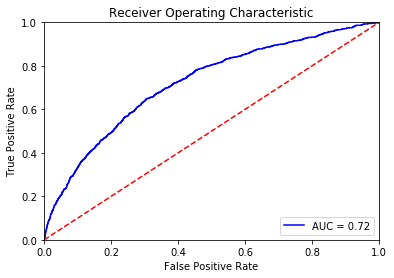

In [114]:
rf_model = RandomForestClassifier(random_state = 1,
                               n_estimators=50, 
                               max_depth = 3, 
                               min_samples_split = 2,
                               min_samples_leaf = 1)
rf_model.fit(train_features, train_labels)
get_roc_curve_auc(rf_model,eval_features,eval_labels)


In [121]:
print(get_accuracy_for_target1_for_thresold(rf_model,train_features,train_labels,.1))
print(get_accuracy_for_target1_for_thresold(rf_model,eval_features,eval_labels,.1))

accuracy for target=1 :  0.39426014840680923
accuracy  : 0.8307377777777778
FP : 0.11992
FN : 0.049342222222222225
None
accuracy for target=1 :  0.3993808049535604
accuracy  : 0.82968
FP : 0.12376
FN : 0.04656
None


##### Conclusion from RF

<br> RF has significant improvement over Base model(Logistic Regression). <br> AUC is now .72 instead of .63<br>
But for lower thresold .1 we can see accuracy for target=1 is 40% which is not good <br. Another observation,
the best model found has maximum depth 3 and number of estimators 50 which is not usual <br>
<br> But FP has lowered and not overfitting

### xgboost

##### Now Extensive random search for XGBoost. As XGBoost is very expensive instead of grid search <br> we are doing random search
##### Total running time is 2 hrs 20 min in local machine

In [287]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [288]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)

In [289]:
%%time
folds = 5
param_comb = 5

Y = train_labels
X = train_features

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, \
                    n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )
random_search.fit(X, Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 126.0min finished


CPU times: user 13min 36s, sys: 2.67 s, total: 13min 39s
Wall time: 2h 19min 40s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x118b3e7d0>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.01, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='warn',

In [291]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

 Best normalized gini score for 5-fold search with 5 parameter combinations:
0.4995718372005442

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}


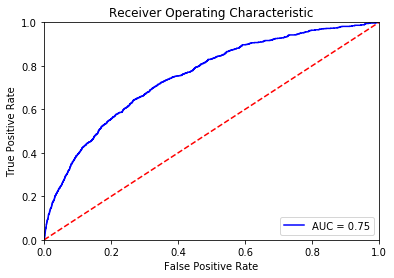

CPU times: user 13min 51s, sys: 2.3 s, total: 13min 54s
Wall time: 13min 57s


In [123]:
%%time
xgb_model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

xgb_model.fit(train_features,train_labels)
get_roc_curve_auc(xgb_model,eval_features,eval_labels)

In [124]:
print(get_accuracy_for_target1_for_thresold(xgb_model,train_features,train_labels,.1))
print(get_accuracy_for_target1_for_thresold(xgb_model,eval_features,eval_labels,.1))

accuracy for target=1 :  0.6457878655608904
accuracy  : 0.7592888888888889
FP : 0.21185777777777778
FN : 0.028853333333333335
None
accuracy for target=1 :  0.5954592363261094
accuracy  : 0.7524
FP : 0.21624
FN : 0.03136
None


#### Conclusion from Phase 1

<br>Starting from AUC .62 at Base model, RF and finally XGBoost showing significant development to AUC .75
<br>But still model is not doing very good job in capturing TARGET 1
<br>When we are getting better accuracy for TARGET 1, FP is also getting high or vice -versa
<br> Too much missing value could be a problem, let's try better method for missing value imputation<br>

### Phase 2
#### Approach

<br> This time we will use Multivariate Imputation of Chained Equation (MICE) for numerical variable
<br> For categorical variables (much less than numerical variables in this data set), we stay with same method as before


In [126]:
features=list(train.columns)
numerical_features=[features[i] for i in range(len(features)) \
                     if ((train[features[i]].dtypes=='float64')|(train[features[i]].dtypes=='int64')) and \
                            features[i]!='TARGET']

In [127]:
%%time
MICE_imputer = IterativeImputer()
train_MICE = train[numerical_features].copy(deep=True)
train_MICE.iloc[:, :] = MICE_imputer.fit_transform(train_MICE)

CPU times: user 5min 33s, sys: 18.9 s, total: 5min 52s
Wall time: 2min 59s


In [128]:
%%time
test_MICE = test[numerical_features].copy(deep=True)
test_MICE.iloc[:, :] = MICE_imputer.fit_transform(test_MICE)

CPU times: user 2min 14s, sys: 9.94 s, total: 2min 24s
Wall time: 1min 4s


In [129]:
imp_mean = SimpleImputer( strategy='most_frequent')
imp_mean.fit(train[categorical_features])
train[categorical_features] = imp_mean.transform(train[categorical_features])
imp_mean.fit(test[categorical_features])
test[categorical_features] = imp_mean.transform(test[categorical_features])

In [130]:
reduce_train=pd.concat([train_MICE,train[list(set(categorical_features)|{'TARGET'})]],axis=1)

In [131]:
reduce_test=pd.concat([test_MICE,test[categorical_features]],axis=1)

In [132]:
print(reduce_train.shape)
print(reduce_test.shape)

(125000, 122)
(48744, 121)


In [133]:
reduce_train=pd.get_dummies(reduce_train)
reduce_test=pd.get_dummies(reduce_test)

In [134]:
reduce_train=reduce_train[list(set(list(reduce_test.columns))|{'TARGET'})]

In [191]:
reduce_train.shape

(125000, 243)

In [192]:
reduce_test.shape

(48744, 242)

In [281]:
to_exclude=[]
test_features=list(reduce_test.columns)
for i in range(len(test_features)):
    adjust_factor=reduce_train[test_features[i]].mean()/reduce_test[test_features[i]].mean()
    if (adjust_factor > 10) or (adjust_factor < .1) :
        to_exclude.append(test_features[i])
    else:
        reduce_test[test_features[i]] *=adjust_factor

In [284]:
test_features=list(set(test_features)-set(to_exclude))

227

In [285]:
reduce_train=reduce_train[list(set(test_features)|{'TARGET'})]
reduce_train.shape

(125000, 228)

In [286]:
reduce_test=reduce_test[test_features]
reduce_test.shape

(48744, 227)

##### Checking if everything is right

In [135]:
set(list(reduce_train.columns))-set(list(reduce_test.columns))

{'TARGET'}

In [136]:
[list(reduce_train.columns)[i] for i in range(len(reduce_train.columns)) if \
         reduce_train[list(reduce_train.columns)[i]].isnull().values.any()==True]

[]

In [137]:
[list(reduce_test.columns)[i] for i in range(len(reduce_test.columns)) if \
         reduce_test[list(reduce_test.columns)[i]].isnull().values.any()==True]

[]

#### Model preperation as before

In [291]:
reduce_train=reduce_train.set_index(['SK_ID_CURR'])
reduce_test=reduce_test.set_index(['SK_ID_CURR'])
indices=reduce_train.index.values
labels = np.array(reduce_train['TARGET'])
model_features= reduce_train.drop('TARGET', axis = 1)
model_features = np.array(model_features)
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(model_features, labels,indices, test_size = 0.1, random_state = 42)

##### Best XGB model from Phase 1

In [292]:
%%time
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)
xgb_model.fit(train_features, train_labels)

CPU times: user 17min 6s, sys: 9.63 s, total: 17min 16s
Wall time: 21min 50s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

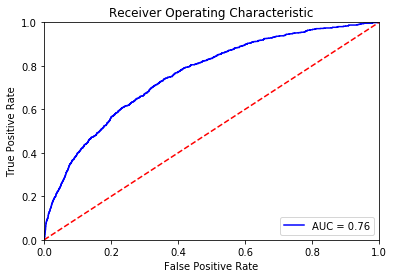

In [309]:
get_roc_curve_auc(xgb_model,eval_features,eval_labels)

In [294]:
get_accuracy_for_target1_for_thresold(xgb_model,eval_features,eval_labels,0.1)

accuracy for target=1 :  0.6037151702786377
accuracy  : 0.75664
FP : 0.21264
FN : 0.03072


In [295]:
df_top_feature_importance=pd.DataFrame(zip(reduce_train.columns,xgb_model.feature_importances_),\
                                       columns=['features','importance'])
df_top_feature_importance.sort_values(by='importance',ascending=False).head(10)

,features,importance
39,EXT_SOURCE_3,0.024586
36,EXT_SOURCE_2,0.016910
221,ORGANIZATION_TYPE_Transport: type 1,0.011316
193,NAME_HOUSING_TYPE_House / apartment,0.010489
205,WALLSMATERIAL_MODE_Monolithic,0.009039
80,FLAG_DOCUMENT_3,0.008515
96,CODE_GENDER_F,0.008435
30,FLAG_OWN_CAR_N,0.008430
23,NAME_INCOME_TYPE_Working,0.008294
46,CODE_GENDER_M,0.008160


#### As we have noticed that best xgb_model at max depth 6, let's try max depth 8 

In [70]:
%%time
xgb_model_dpth8 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
                  learning_rate=0.02, max_delta_step=0, max_depth=8,
                  min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
                  nthread=1, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                  silent=True, subsample=0.6, verbosity=1)
xgb_model_dpth8.fit(train_features, train_labels)

CPU times: user 24min 46s, sys: 4.5 s, total: 24min 51s
Wall time: 24min 58s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

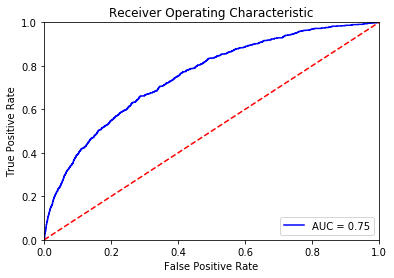

In [77]:
get_roc_curve_auc(xgb_model_dpth8,eval_features,eval_labels)

In [79]:
print(get_accuracy_for_target1_for_thresold(xgb_model_dpth8,eval_features,eval_labels,0.1))
print(get_accuracy_for_target1_for_thresold(xgb_model_dpth8,eval_features,eval_labels,0.15))
print(get_accuracy_for_target1_for_thresold(xgb_model_dpth8,eval_features,eval_labels,0.2))

accuracy for target=1 :  0.5675954592363261
accuracy  : 0.76952
FP : 0.19696
FN : 0.03352
None
accuracy for target=1 :  0.41382868937048506
accuracy  : 0.85416
FP : 0.1004
FN : 0.04544
None
accuracy for target=1 :  0.29411764705882354
accuracy  : 0.88968
FP : 0.0556
FN : 0.05472
None


#### Conclusion from MICE with XGB

<br> After MICE and increasing depth for XGB, we don't see any significant development in model performance<br>
We can get 60% accuracy for TARGET 1 but in the cost of 20% FP.If we want to decrease FP we have to comprise <br>
in capturing TARGET 1
    

#### Let's try different approach - LightGBM

<br> For limited time we will not do extensive grid search <br>

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's auc: 0.889748	training's binary_logloss: 0.201621	valid_1's auc: 0.744511	valid_1's binary_logloss: 0.250981


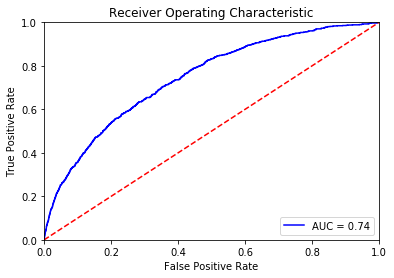

In [229]:
X_train, X_valid, Y_train, Y_valid = train_test_split\
                                (train_features, train_labels, random_state=7, test_size=0.2)
# model
lgb_model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=100,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=15,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )
    
lgb_model.fit(X_train,Y_train,
            eval_set= [(X_train,Y_train),(X_valid,Y_valid)], 
            eval_metric='auc', verbose=200, early_stopping_rounds=100
           )
get_roc_curve_auc(lgb_model,eval_features,eval_labels)


In [267]:
print(get_accuracy_for_target1_for_thresold(lgb_model,eval_features,eval_labels,0.1))

accuracy for target=1 :  0.56656346749226
accuracy  : 0.75664
FP : 0.20976
FN : 0.0336
None


#### Almost same story as XGB. Not much development

<br> As we are not getting much development after XGB model with max_depth=5,<br>
Final submission will be on this model

#### Implement on Test and Final Submission

In [296]:
sample_submission=pd.read_csv(file_path+"/sample_submission.csv")

In [300]:
sample_submission=sample_submission.drop(['TARGET'],axis=1)

In [305]:
sample_submission.columns

Index(['SK_ID_CURR'], dtype='object')

In [302]:
test_indices=reduce_test.index.values
test_features = np.array(reduce_test)

In [308]:
xgb_model.predict_proba

<bound method XGBClassifier.predict_proba of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)>

In [310]:
df_result=pd.DataFrame(list(zip(test_indices,xgb_model.predict_proba(test_features)[:,0],\
                    xgb_model.predict_proba(test_features)[:,1])),\
                    columns=['SK_ID_CURR','prob_0','prob_1'])
df_result['TARGET']=np.where(df_result['prob_1']>.1,1,0)

In [314]:
df_result[df_result['TARGET']==1].shape[0]/df_result.shape[0]

0.3069916297390448

In [315]:
df_result=df_result.drop(['prob_0','prob_1'],axis=1)

In [316]:
sample_submission=pd.merge(sample_submission,df_result,on='SK_ID_CURR')
sample_submission.to_csv('sample_submission.csv', index=False)

### Conclusion and Future work 

<br> In this project, dataset was not very balanced only 8% in one class and rest other class <br>
Missing value percentage was also high <br> That suggests,if we make all prediction to zero still model 
accuracy will be 92% if the distribution in test is same as training set.<br> For some practical cases,
for example,fraud capturing TARGET 1 is important, This is why I created another measure for accuracy
when TARGET at 1<br>In this work, modeling was started with minimal EDA <br>
Primirily missing values were replaced by simple techniques. Base model came with .63 AUC score.<br>
AUC is improved to .75 after finding cv,hyperparameter tuning<br> From feature importance point of view
one variable EXT_SOURCE_3 is the highest 2% important all other parametrs contributing rest.
<br> For improvement of this model, in depth EDA is required to get better understanding of the data<br>
Missing value imputation technique, MICE did not work very well<br> Dimension Reduction technique 
like PCA can be used in next phase <br> Better feature engineering required<br> More hyperparameter tuning and other modeling techniques need to explore
<br> Also stalking(ensembling or combining by some percentage) different models, can be useful 